In [1]:
import pennylane as qml
from pennylane import numpy as pnp
import os, json
import numpy as np
from collections import Counter
import pandas as pd
from datetime import datetime

from scipy.sparse import coo_matrix
from scipy.sparse.linalg import eigsh

from wesszumino import build_wz_hamiltonian, pauli_str_to_op

import git
repo = git.Repo('.', search_parent_directories=True)
repo_path = repo.working_tree_dir

In [2]:
def apply_pauli_to_bitstring(pauli_str, bitstring):
    """
    Apply a Pauli string (like "IXYZ...") to a computational basis bitstring.

    Returns:
        phase (complex), out_bitstring (str)
    """
    phase = 1.0 + 0.0j
    out = list(bitstring)

    for q, (p, b_char) in enumerate(zip(pauli_str.upper(), bitstring)):
        b = 1 if b_char == "1" else 0

        if p == "I":
            continue
        elif p == "X":
            out[q] = "0" if b else "1"
        elif p == "Z":
            if b:
                phase *= -1
        elif p == "Y":
            out[q] = "0" if b else "1"
            phase *= (1j if b == 0 else -1j)  # i * (-1)^b
        else:
            raise ValueError(f"Bad Pauli char '{p}' at qubit {q}")

    return phase, "".join(out)


def reduced_matrix_from_pauli_terms(pauli_terms, basis_states):

    """
    Build reduced Hamiltonian matrix from explicit Pauli terms.

    pauli_terms: list of (coeff, pauli_str)
        e.g. [(0.5, "ZIIII"), (-1.2, "XXIYZ"), ...]
    basis_states: list of bitstrings, all same length n
        e.g. top_states from counts
    """
    basis_states = [s.strip() for s in basis_states]
    n = len(basis_states[0])
    m = len(basis_states)
    idx = {s: i for i, s in enumerate(basis_states)}

    H_red = np.zeros((m, m), dtype=complex)

    for coeff, pstr in pauli_terms:
        pstr = pstr.strip().upper()
        for ket in basis_states:
            phase, out_state = apply_pauli_to_bitstring(pstr, ket)
            if out_state in idx:
                i = idx[out_state]
                j = idx[ket]
                H_red[i, j] += coeff * phase

    return H_red



def reduced_sparse_matrix_from_pauli_terms(pauli_terms, basis_states):
    """
    Build reduced Hamiltonian as a sparse matrix from explicit Pauli terms.

    pauli_terms: list of (coeff, pauli_str)
        e.g. [(0.5, "ZIIII"), (-1.2, "XXIYZ"), ...]
    basis_states: list of bitstrings, all same length n
        e.g. top_states from counts

    Returns
    -------
    H_red : scipy.sparse.csr_matrix (complex)
        Reduced Hamiltonian in the basis given by basis_states
    """
    # Clean basis states
    basis_states = [s.strip() for s in basis_states]
    n = len(basis_states[0])
    m = len(basis_states)

    # Map bitstring -> basis index
    idx = {s: i for i, s in enumerate(basis_states)}

    # Lists for COO data
    rows = []
    cols = []
    data = []

    for coeff, pstr in pauli_terms:
        pstr = pstr.strip().upper()
        # Act on each basis state |ket>
        for ket in basis_states:
            phase, out_state = apply_pauli_to_bitstring(pstr, ket)
            if out_state in idx:
                i = idx[out_state]   # row index  (bra = out_state)
                j = idx[ket]         # column index (ket)
                value = coeff * phase

                # Store non-zero contribution
                if value != 0:
                    rows.append(i)
                    cols.append(j)
                    data.append(value)

    # Build sparse matrix in COO then convert to CSR
    H_red_coo = coo_matrix((data, (rows, cols)),
                           shape=(m, m),
                           dtype=np.complex128)
    H_red = H_red_coo.tocsr()  # sums duplicate (i,j) entries

    return H_red



def op_to_full_pauli_string(op, wire_order):
    """
    Convert a single PennyLane Pauli word into a full string over wire_order.
    Example output: "IIXZY"
    """
    wire_pos = {w: i for i, w in enumerate(wire_order)}
    n = len(wire_order)
    chars = ["I"] * n

    def walk(o):
        # Products / tensors expose operands
        if hasattr(o, "operands") and o.operands is not None:
            for sub in o.operands:
                walk(sub)
            return

        name = o.name
        if name in ("PauliX", "X"):
            c = "X"
        elif name in ("PauliY", "Y"):
            c = "Y"
        elif name in ("PauliZ", "Z"):
            c = "Z"
        elif name in ("Identity", "I"):
            c = "I"
        else:
            raise ValueError(f"Unexpected operator in Pauli word: {name}")

        for w in o.wires:
            chars[wire_pos[w]] = c

    walk(op)
    return "".join(chars)


def pauli_terms_from_operator(H_pauli, wire_order):
    """
    Extract list of (coeff, pauli_str) from a PennyLane Hamiltonian / Sum.
    """
    if not hasattr(H_pauli, "terms"):
        raise TypeError("H_pauli has no .terms(); pass explicit pauli_terms instead.")

    coeffs, ops = H_pauli.terms()
    terms = []
    for c, o in zip(coeffs, ops):
        pstr = op_to_full_pauli_string(o, wire_order)
        terms.append((complex(c), pstr))
    return terms



In [38]:
N = 4
a = 1.0
c = -0.2

potential = "linear"
#potential = 'quadratic'
boundary_condition = 'dirichlet'
#boundary_condition = 'periodic'

cutoff = 8
cutoffs = [4]

dt=1.0
times = [0.1, 0.2, 0.3, 0.4, 0.5, 1.0, 2.0, 3.0]
D=20
DS = [15]
n_steps=1
ns = [1,2,3]

all_data = []

if potential == 'quadratic':
    folder = 'C' + str(abs(c)) + '/' + 'N'+ str(N)
else:
    folder = 'N'+ str(N)

for cutoff in cutoffs:

    print(f"Cutoff: {cutoff}")

    H_path = os.path.join(repo_path, r"SUSY\Wess-Zumino\Analyses\Model Checks\HamiltonianData", boundary_condition, potential, folder, f"{potential}_{cutoff}.json")
    with open(H_path, 'r') as file:
        H_data = json.load(file)

    pauli_coeffs = H_data['pauli_coeffs']
    pauli_strings = H_data['pauli_terms']
    pauli_terms = [pauli_str_to_op(t) for t in pauli_strings]

    num_qubits = H_data['num_qubits']

    dense_H_size = H_data['H_size']

    eigenvalues = H_data['eigenvalues']
    min_eigenvalue = np.min(eigenvalues)

    print(f"Min eignvalue: {min_eigenvalue.real}")

    H_pauli = qml.Hamiltonian(pauli_coeffs, pauli_terms)

    nb = int(np.log2(cutoff))
    n = 1 + nb
    fw = [i * n for i in range(N)]

    pairs = [(fw[i], fw[i+1]) for i in range(len(fw)-1)]
    print(pairs)
  
    dev = qml.device("default.qubit", wires=num_qubits, shots=10000)
    @qml.qnode(dev)
    def circuit(t, n_steps):

        #Dirichlet-Linear
        #basis = [0]*n + [1] + [0]*nb #N2
        #basis = [0]*n + [1] + [0]*nb + [0]*n #N3
        basis = [0]*n + [1] + [0]*nb + [0]*n + [1] + [0]*nb #N4
        #basis = [0]*n + [1] + [0]*nb + [0]*n + [1] + [0]*nb + [0]*n #N5

        #Dirichlet-quadratic c=-0.2
        #basis = [0]*num_qubits #N2 cutoff != 4
        #basis = [0]*n + [1] + [0]*nb #N2 cutoff = 4
        #basis = [0]*n + [1] + [0]*nb + [0]*n #N3
 
        #Dirichlet-Linear
        print(basis)
        
        qml.BasisState(basis, wires=list(range(num_qubits)))

        for pair in pairs:
            #qml.FermionicSingleExcitation(np.pi/2, wires=pair)
            qml.CRY(np.pi/2, wires=pair)

        #qml.TrotterProduct(H_pauli, time=t, n=n_steps) # this forms dense
        qml.ApproxTimeEvolution(H_pauli, t, n_steps)

        return qml.counts(wires=list(range(num_qubits)))

    
    times = [k * dt for k in range(D)] 
    print("Getting counts")
    all_counts = [circuit(t=t_k, n_steps=n_steps) for t_k in times]

    print("Combining samples")
    samples = Counter()
    for d in all_counts:
        samples.update(d)

    print("Soring states")
    sorted_states = sorted(samples.items(), key=lambda x: x[1], reverse=True)
    top_states = [s for s, c in sorted_states]
    idx = [int(s, 2) for s in top_states]

    print("Reducing H")
    pauli_terms = pauli_terms_from_operator(H_pauli, wire_order=list(range(num_qubits)))
    #H_reduced = reduced_matrix_from_pauli_terms(pauli_terms, top_states)
    H_reduced = reduced_sparse_matrix_from_pauli_terms(pauli_terms, top_states)
    

    print("finding eigevalues")
    t1 = datetime.now()
    es = eigsh(H_reduced, k=1, which="SA", return_eigenvectors=False)
    #es, evs = np.linalg.eig(H_reduced)
    HRt = datetime.now() - t1

    mi = np.argmin(es)
    me = es[mi]

    print("Saving")
    row = {"potential": potential,
           "cutoff": cutoff,
           "dt": dt,
           "D": D,
           "n_steps": n_steps,
           "H_reduced_size": H_reduced.shape,
           "dense_H_size": dense_H_size,
           "reduction": (1 - (H_reduced.shape[0] / dense_H_size[0]))*100,
           "H_exact_e": min_eigenvalue.real,
           "H_reduced_e": me.real,
           "diff": np.abs(min_eigenvalue-me)
           }
    
    all_data.append(row)


Cutoff: 4
Min eignvalue: -6.460202619670289e-05
[(0, 3), (3, 6), (6, 9)]
Getting counts
[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0]
[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0]
[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0]
[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0]
[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0]
[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0]
[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0]
[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0]
[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0]
[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0]
[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0]
[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0]
[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0]
[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0]
[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0]
[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0]
[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0]
[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0]
[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0]
[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0]
Combining samples
Soring states
Reducing H
finding eigevalues
Saving


In [39]:
df = pd.DataFrame(all_data)
df

,potential,cutoff,dt,D,n_steps,H_reduced_size,dense_H_size,reduction,H_exact_e,H_reduced_e,diff
0,linear,4,1.0,20,1,"(640, 640)","[4096, 4096]",84.375,-0.000065,-0.000065,2.120022e-16


In [30]:
df = pd.DataFrame(all_data)
df

,potential,cutoff,dt,D,n_steps,H_reduced_size,dense_H_size,reduction,H_exact_e,H_reduced_e,diff
0,linear,8,1.0,40,1,"(77093, 77093)","[1048576, 1048576]",92.647839,-7.037942e-08,0.000028,0.000028


In [28]:
df = pd.DataFrame(all_data)
df

,potential,cutoff,dt,D,n_steps,H_reduced_size,dense_H_size,reduction,H_exact_e,H_reduced_e,diff
0,linear,8,1.0,30,1,"(72873, 72873)","[1048576, 1048576]",93.050289,-7.037942e-08,0.00002,0.00002


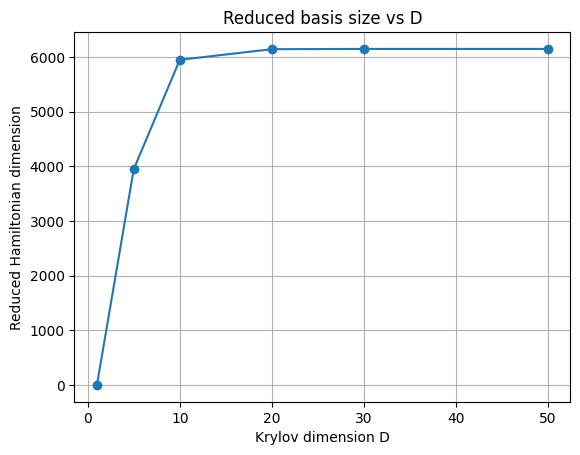

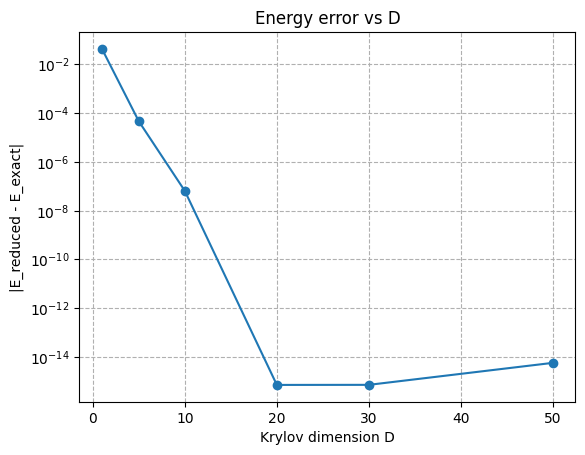

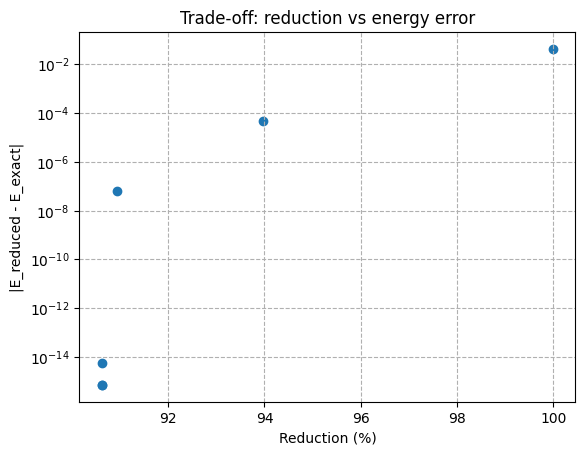

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming your DataFrame is called df

# --- Clean up / helper columns ---

# Extract dimension from "(n, n)" string/tuple
if isinstance(df["H_reduced_size"].iloc[0], str):
    df["dim"] = df["H_reduced_size"].str.extract(r"\((\d+),")[0].astype(int)
else:
    # if it's already a tuple like (n, n)
    df["dim"] = df["H_reduced_size"].apply(lambda x: x[0])

df["abs_diff"] = df["diff"].abs()

# --- 1. Dimension vs D ---

plt.figure()
plt.plot(df["D"], df["dim"], marker="o")
plt.xlabel("Krylov dimension D")
plt.ylabel("Reduced Hamiltonian dimension")
plt.title("Reduced basis size vs D")
plt.grid(True)
plt.show()

# --- 2. Error vs D (log scale) ---

plt.figure()
plt.plot(df["D"], df["abs_diff"], marker="o")
plt.xscale("linear")
plt.yscale("log")
plt.xlabel("Krylov dimension D")
plt.ylabel(r"|E_reduced - E_exact|")
plt.title("Energy error vs D")
plt.grid(True, which="both", ls="--")
plt.show()

# --- 3. Optional: Reduction vs Error ---

plt.figure()
plt.scatter(df["reduction"], df["abs_diff"])
plt.yscale("log")
plt.xlabel("Reduction (%)")
plt.ylabel(r"|E_reduced - E_exact|")
plt.title("Trade-off: reduction vs energy error")
plt.grid(True, which="both", ls="--")
plt.show()


In [6]:
pd.DataFrame(all_data)

,potential,cutoff,dt,D,n_steps,H_reduced_size,dense_H_size,H_exact_e,H_reduced_e,diff
0,linear,8,1.0,1,1,"(5, 5)","[65536, 65536]",-3.759967e-08,4.232471e-02,4.232474e-02
1,linear,8,1.0,3,1,"(1496, 1496)","[65536, 65536]",-3.759967e-08,5.563502e-05,5.567262e-05
2,linear,8,1.0,10,1,"(5910, 5910)","[65536, 65536]",-3.759967e-08,-3.203343e-08,5.566244e-09
3,linear,8,1.0,20,1,"(6141, 6141)","[65536, 65536]",-3.759967e-08,-3.759072e-08,8.946279e-12


In [54]:
pd.DataFrame(all_data)

,potential,cutoff,dt,D,n_steps,H_reduced_size,dense_H_size,H_exact_e,H_reduced_e,diff
0,linear,8,1.0,1,1,"(5, 5)","[65536, 65536]",-3.759967e-08,4.232471e-02,4.232474e-02
1,linear,8,1.0,2,1,"(217, 217)","[65536, 65536]",-3.759967e-08,2.984414e-04,2.984790e-04
2,linear,8,1.0,3,1,"(1510, 1510)","[65536, 65536]",-3.759967e-08,3.438742e-05,3.442502e-05
3,linear,8,1.0,4,1,"(2947, 2947)","[65536, 65536]",-3.759967e-08,8.056665e-06,8.094265e-06
4,linear,8,1.0,5,1,"(3940, 3940)","[65536, 65536]",-3.759967e-08,3.446835e-05,3.450595e-05
5,linear,8,1.0,10,1,"(5934, 5934)","[65536, 65536]",-3.759967e-08,2.904943e-07,3.280940e-07
6,linear,8,1.0,20,1,"(6144, 6144)","[65536, 65536]",-3.759967e-08,-3.759967e-08,2.922075e-15


In [ ]:
N = 3
a = 1.0
c = -0.8

potential = "linear"
#potential = 'quadratic'
boundary_condition = 'dirichlet'
#boundary_condition = 'periodic'

cutoff = 2
cutoffs = [2]

dt=2.0
#times = [0.1, 0.2, 0.3, 0.4, 0.5, 1.0, 2.0]
D=3
DS = [1,2,3,4,5,10,20]
n_steps=1
ns = [1,2,3,4,5]

all_data = []


for cutoff in cutoffs:

    print(f"Cutoff: {cutoff}")

    H_pauli, num_qubits = build_wz_hamiltonian(
        cutoff,
        N,
        a,
        c=c,
        m=1.0,
        potential=potential,
        boundary_condition=boundary_condition,
        remove_zero_terms=True
    )

    H = qml.matrix(H_pauli, wire_order=list(range(num_qubits)))

    t1 = datetime.now()
    eigenvalues, eigenvectors = np.linalg.eig(H)
    Ht = datetime.now() - t1

    min_index = np.argmin(eigenvalues)
    min_eigenvalue = eigenvalues[min_index]

    dev = qml.device("default.qubit", wires=num_qubits, shots=10000)
    @qml.qnode(dev)
    def circuit(t, n_steps):

        #basis = [0,0,0,1,0,0,1,0,0,0,0,0]
        #basis = [0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0]
        basis = [1] + [0]*(num_qubits-1)
        qml.BasisState(basis, wires=list(range(num_qubits)))

        #qml.FermionicSingleExcitation(3.5837816671067175, wires=[0, 2])
        #qml.FermionicSingleExcitation(6.6864967676503, wires=[2, 4])

        #qml.FermionicSingleExcitation(3.5837816671067175, wires=[0, 3])
        #qml.FermionicSingleExcitation(6.6864967676503, wires=[3, 6])

        qml.FermionicSingleExcitation(3.5837816671067175, wires=[0, 4])
        qml.FermionicSingleExcitation(6.6864967676503, wires=[4, 8])

        #qml.FermionicSingleExcitation(3.5744904941650586, wires=[4, 6])
        #qml.FermionicSingleExcitation(6.689916101716141, wires=[0, 2])
        #qml.FermionicSingleExcitation(6.67626444815948, wires=[2, 4])


        qml.TrotterProduct(H_pauli, time=t, n=n_steps)

        return qml.counts(wires=list(range(num_qubits)))

    
    times = [k * dt for k in range(D)] 
    all_counts = [circuit(t=t_k, n_steps=n_steps) for t_k in times]

    samples = Counter()
    for d in all_counts:
        samples.update(d)

    sorted_states = sorted(samples.items(), key=lambda x: x[1], reverse=True)
    top_states = [s for s, c in sorted_states]
    idx = [int(s, 2) for s in top_states]

    #H_reduced = H[np.ix_(idx, idx)]
    pauli_terms = pauli_terms_from_operator(H_pauli, wire_order=list(range(num_qubits)))
    H_reduced = reduced_matrix_from_pauli_terms(pauli_terms, top_states)

    t1 = datetime.now()
    es, evs = np.linalg.eig(H_reduced)
    HRt = datetime.now() - t1

    mi = np.argmin(es)
    me = es[mi]

    row = {"potential": potential,
           "cutoff": cutoff,
           "dt": dt,
           "D": D,
           "n_steps": n_steps,
           "H_size": H.shape,
           "H_reduced_size": H_reduced.shape,
           "H_etime": str(Ht),
           "H_reduced_etime": str(HRt),
           "H_exact_e": min_eigenvalue.real,
           "H_reduced_e": me.real,
           "diff": np.abs(min_eigenvalue-me)
           }
    
    all_data.append(row)


In [ ]:
df = pd.DataFrame(all_data)
df

In [ ]:
df = pd.DataFrame(all_data)
df

In [ ]:
df = pd.DataFrame(all_data)
df

In [ ]:
df = pd.DataFrame(all_data)
df

In [ ]:
df = pd.DataFrame(all_data)
df

In [215]:
folder_path = os.path.join(repo_path, r"SUSY\SUSY QM\PennyLane\COBYQA\PauliDecomp\SBKQD\Files\NoInitial", potential)
os.makedirs(folder_path)
df.to_excel(os.path.join(folder_path, "SBKQD.xlsx"), index=False)

In [ ]:
H_pauli.ops